In [4]:
!pip install transformers datasets scikit-learn pandas

In [ ]:
import pandas as pd
import torch
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments)
from transformers import BertForSequenceClassification
import numpy as np
from datasets import Dataset
from collections import Counter
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
model_name = "bert-base-multilingual-cased"

params = {"learning_rate": 3e-5, "batch_size": 64, "epochs": 4, "weight_decay": 0.001, "warmup_ratio": 0.1}

In [ ]:
# Verifica si hay GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


drive.mount('/content/drive')
# ✅ Carga de datos
df = pd.read_csv("/content/drive/MyDrive/ALBA/diagnosticos_F20_F20.89_con_descripcion.csv", sep="|")

# Fusiona columnas de diagnóstico en texto
diag_cols = [col for col in df.columns if col.startswith("Diag")]
df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
df["label"] = df["DIAG PSQ"].apply(lambda x: 1 if "Esquizofrenia" in x and "Otros tipos de esquizofrenia" not in x else 0)
seed = int(time.time_ns() % (2**32))
np.random.seed(seed)
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], stratify=df["label"], test_size=0.2, random_state=seed)
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})
print("Entrenamiento:", Counter(y_train))
print("Evaluación:", Counter(y_test))

Usando dispositivo: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Entrenamiento: Counter({0: 1252, 1: 593})
Evaluación: Counter({0: 313, 1: 149})


Total ejemplos: 2307
Clases únicas: [0 1]


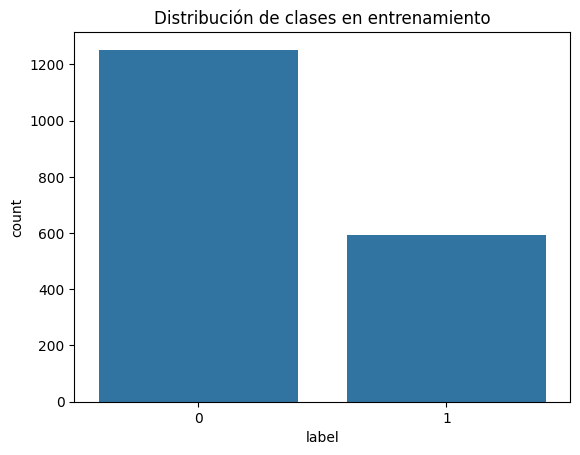

In [ ]:
print(f"Total ejemplos: {len(df)}")
print(f"Clases únicas: {df['label'].unique()}")

sns.countplot(x=y_train)
plt.title("Distribución de clases en entrenamiento")
plt.show()

In [ ]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds)
    }

def evaluate_model(model_name, learning_rate, batch_size, epochs, weight_decay, warmup_ratio):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

    train_tokenized = train_dataset.map(tokenize, batched=True)
    test_tokenized = test_dataset.map(tokenize, batched=True)

    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    training_args = TrainingArguments(
        output_dir="/content/drive/MyDrive/ALBA/modelos_buenos/" + model_name + "/results",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        eval_strategy="epoch",
        logging_steps=10,
        disable_tqdm=True,
        save_strategy="no",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate()
    print(f"Evaluating {model_name} with learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
    print(f"Accuracy: {metrics['eval_accuracy']:.3f}, F1: {metrics['eval_f1']:.3f}, Precision: {metrics['eval_precision']:.3f}, Recall: {metrics['eval_recall']:.3f}")
    return model, tokenizer, metrics

In [ ]:
# ✅ Loop para probar todos los modelos y combinaciones
resultados = []

print(f"\n🔍 Probando modelo {model_name} con {params}")
model, tokenizer, metrics = evaluate_model(model_name, **params)
resultados.append({
    "modelo": model_name,
    "learning_rate": params["learning_rate"],
    "batch_size": params["batch_size"],
    "epochs": params["epochs"],
    "accuracy": metrics["eval_accuracy"],
    "f1": metrics["eval_f1"],
    "precision": metrics["eval_precision"],
    "recall": metrics["eval_recall"]
})
print(f"Accuracy: {metrics['eval_accuracy']:.3f}, F1: {metrics['eval_f1']:.3f}, Precision: {metrics['eval_precision']:.3f}, Recall: {metrics['eval_recall']:.3f}")

# ✅ Resultados ordenados
df_resultados = pd.DataFrame(resultados).sort_values(by="f1", ascending=False)
print("\n🏆 Mejores resultados por F1:")
print(df_resultados.head(10))

df_resultados["score"] = df_resultados["f1"] * 0.6 + df_resultados["recall"] * 0.4
df_ordenado = df_resultados.sort_values(by="score", ascending=False)
print("\n📊 Mejores modelos por score combinado (f1 + recall):")
print(df_ordenado.head(10))

save_path = "/content/drive/MyDrive/ALBA/modelos_buenos/" + model_name
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


🔍 Probando modelo bert-base-multilingual-cased con {'learning_rate': 3e-05, 'batch_size': 64, 'epochs': 4, 'weight_decay': 0.001, 'warmup_ratio': 0.1}


Map:   0%|          | 0/1845 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6677, 'grad_norm': 1.120395302772522, 'learning_rate': 2.25e-05, 'epoch': 0.3448275862068966}
{'loss': 0.6278, 'grad_norm': 1.1402558088302612, 'learning_rate': 2.798076923076923e-05, 'epoch': 0.6896551724137931}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.5881775617599487, 'eval_accuracy': 0.6774891774891775, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 3.7025, 'eval_samples_per_second': 124.78, 'eval_steps_per_second': 2.161, 'epoch': 1.0}
{'loss': 0.5987, 'grad_norm': 1.8920344114303589, 'learning_rate': 2.509615384615385e-05, 'epoch': 1.0344827586206897}
{'loss': 0.5777, 'grad_norm': 1.4660446643829346, 'learning_rate': 2.2211538461538464e-05, 'epoch': 1.3793103448275863}
{'loss': 0.5878, 'grad_norm': 3.248431444168091, 'learning_rate': 1.932692307692308e-05, 'epoch': 1.7241379310344827}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.5498534440994263, 'eval_accuracy': 0.6774891774891775, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 3.3895, 'eval_samples_per_second': 136.302, 'eval_steps_per_second': 2.36, 'epoch': 2.0}
{'loss': 0.5362, 'grad_norm': 2.264381170272827, 'learning_rate': 1.6442307692307695e-05, 'epoch': 2.0689655172413794}
{'loss': 0.5098, 'grad_norm': 2.6281354427337646, 'learning_rate': 1.3557692307692308e-05, 'epoch': 2.413793103448276}
{'loss': 0.5522, 'grad_norm': 1.8887253999710083, 'learning_rate': 1.0673076923076923e-05, 'epoch': 2.7586206896551726}
{'eval_loss': 0.5256787538528442, 'eval_accuracy': 0.6926406926406926, 'eval_f1': 0.3826086956521739, 'eval_precision': 0.5432098765432098, 'eval_recall': 0.2953020134228188, 'eval_runtime': 3.5036, 'eval_samples_per_second': 131.866, 'eval_steps_per_second': 2.283, 'epoch': 3.0}
{'loss': 0.4985, 'grad_norm': 3.4969091415405273, 'learning_rate': 7.78846153846154e-06, 'epoch': 3.103448275862069}
{'loss': 

('/content/drive/MyDrive/ALBA/modelos_buenos/bert-base-multilingual-cased/tokenizer_config.json',
 '/content/drive/MyDrive/ALBA/modelos_buenos/bert-base-multilingual-cased/special_tokens_map.json',
 '/content/drive/MyDrive/ALBA/modelos_buenos/bert-base-multilingual-cased/vocab.txt',
 '/content/drive/MyDrive/ALBA/modelos_buenos/bert-base-multilingual-cased/added_tokens.json',
 '/content/drive/MyDrive/ALBA/modelos_buenos/bert-base-multilingual-cased/tokenizer.json')

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np
import pandas as pd
import random
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments)
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


drive.mount('/content/drive')
# ✅ Carga de datos
df = pd.read_csv("/content/drive/MyDrive/ALBA/diagnosticos_F20_F20.89_con_descripcion.csv", sep="|")

# Fusiona columnas de diagnóstico en texto
diag_cols = [col for col in df.columns if col.startswith("Diag")]
df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
df["label"] = df["DIAG PSQ"].apply(lambda x: 1 if "Esquizofrenia" in x and "Otros tipos de esquizofrenia" not in x else 0)
seed = int(time.time_ns() % (2**32))
np.random.seed(seed)
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], stratify=df["label"], test_size=0.2, random_state=seed)
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

model_name = "bert-base-multilingual-cased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Carga del tokenizer y modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokeniza tus datos (asumiendo train_df y val_df están definidos)
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")


# Métricas personalizadas
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./mejor_modelo",
    learning_rate=3e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.001,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42
)

# Entrenamiento
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


Usando dispositivo: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-3424242029.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.r

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 1